In [ ]:
!pip install  cvxpy osqp

In [3]:
import numpy as np
import cvxpy as cp
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt

In [112]:
# Quadrotor parameters
m_q = 1.0 # kg
I_xx = 0.1 # kg.m^2
l_q = 0.3 # m, length of the quadrotor
g = 9.81

# Controller parameters
params = {
    'gamma': 2.5334991360748047,
    'gamma2': 6.8100624327890635,
    'ky': 0.8060171897461441,
    'kz': 1.666562251062336,
    'kk': 1.5596285831810783,
    'kp1': 7.612698055588866,
    'kp2': 0.04242324430833757,
    'kp3': 0.7556504455549217
}


## Define 2D planar quadrotor models

The model of the planar quadrotor is from an [Aerial Robitics lecture](https://www.coursera.org/lecture/robotics-flight/2-d-quadrotor-control-kakc6) on couyrsera.

The state of the planar quadrotor is defined as

\begin{equation}
(y, \dot{y}, z, \dot{z}, \phi, \dot{\phi})
\end{equation}
where:
- $(y, z)$ is the position.
- $\phi$ is the roll angle.

The control input consists of:
- The total thrust $u_1$.
- The torque provided by the rotors $u_2$.

The dynamics of the planar quadrotor are described by the following equations:
$$
\begin{align}
    \ddot{y} &= \frac{-u_1}{m_q}\cdot{\sin(\phi)} \\
    \ddot{z} &= -g + \frac{u_1}{m_q}\cdot{\cos(\phi)} \\
    \ddot{\phi} &= \frac{u_2}{I_{xx}}
\end{align}
$$

where $m_q$ is the mass of the quadrotor, $I_{xx}$ is the inertia moment of the quadrotor, and $g$ is the gravity.

In [ ]:
def dynamics_ode(t, state, u1, u2, m_q=m_q, g=g, I_xx=I_xx):
    """
    Calculate the next state of the system based on the current state and control inputs.
    :param u1: Thrust input
    :param u2: Moments input
    :return: New state
    """
    y, y_dot, z, z_dot, phi, phi_dot = state
    # Quadrotor dynamics
    y_ddot = -u1 * np.sin(phi) / m_q
    z_ddot = -g + u1 * np.cos(phi) / m_q
    phi_ddot = u2 / I_xx

    return np.array([y_dot, y_ddot, z_dot, z_ddot, phi_dot, phi_ddot])

## Define QP controllers

The controller design discussed here is adapted from the research presented by Guofan Wu and Koushil Sreenat. The full paper is available [here](https://hybrid-robotics.berkeley.edu/publications/ACC2016_Safety_Control_Planar_Quadrotor.pdf).

> Wu, Guofan, and Koushil Sreenath. "Safety-critical control of a planar quadrotor." 2016 American control conference (ACC). IEEE, 2016.

### Overview of the Controller Architecture
The proposed architecture divides the control system into two main components: the position-level controller and the orientation-level controller. Each targets specific aspects of the quadrotor's flight dynamics.


### Position-level controller
The position-level controller addresses the challenges associated with the quadrotor being an under-actuated system, which means direct thrust and moment controls are not present in both the Control Barrier Function (CBF) and Control Lyapunov Function (CLF). To address the issue, the controller employs virtual controls using the following dynamics:
$$
\begin{align}
    \ddot{y} &= m_q \cdot{u_{v1}} \\
    \ddot{z} &= m_q \cdot{u_{v2}}
\end{align}
$$
Here, $u_{v1}$ and $u_{v2}$ are virtual controls. The controller optimizes these controls by solving a Quadratic Programming (QP) problem that incorporates both CLF and CBF constraints:
$$
\begin{align}
    u^*_{v1},u^*_{v2} &= \text{argmin  } u^2_{v1} + u^2_{v2} + 10\cdot{\delta} \\
    \text{s.t.} & \\
    &\dot{V}_p + \gamma V_p \le 0 & \text{(CLF constraint)}\\
    & \ddot{h_p} + \beta \dot{h_p} + \alpha h_p \le \delta & \text{(CBF constraint)}
\end{align}
$$
The position error $e_p=[y-y^*, z-z^*]$ and the velocity error $e_v=[\dot{y}-\dot{y}^*, \dot{z}-\dot{z}^*]$ define the Lyapunov function $V_p$ and barrier function $h_p$ as:
$$
\begin{align}
    V_p(y,z) &=  k_1 \cdot{e_p}^Te_p + m_q \cdot{e_v}^Te_v + k_2 \cdot{e_p}^T \cdot{e_v}\\
    h_p(y,z) &= (y-y_{o,j})^2 + (z-z_{o,j})^2 - r_j,&j=1,2,...,k
\end{align}
$$
The paramewters $k_1,k_2 \ge 0$ are parameters to be tuned and the obstacles are characterized by their Y and Z positions y_{o,j}$, $z_{o,j}$ and radii $r_j$.

After solving the QP, desired state for the orientation-level controller is then calculated. Please refer to section V of the paper mentioned above for the calculation.


### Orientation-level conrtoller
The orientation-level controller uses desired states from the position-level output and solves another QP problem to determine the actual commands for the quadrotor. This controller incorporates the full dynamics of the quadrotor in its CBF constraint and is defined as follows:
$$
\begin{align}
    u^*_{1},u^*_{2} &= \text{argmin  } (u_1-u^*_1)^2 + u^2_2 + 10^2\delta_{CBF} + 10^5\delta_{CLF} \\
    \text{s.t.} & \\
    &\dot{V}_o + \gamma V_o \le 0 & \text{(CLF constraint)}\\
    & \ddot{h_o} + \beta \dot{h_o} + \alpha h_o \le \delta & \text{(CBF constraint)}
\end{align}
$$

For further details on the formulation and implementation, please refer to Section V of the cited paper.

In [167]:
def position_qp_controller(state, obs_center, obs_radius, target_position, params=None):
    # Get parameters
    if params is not None:
        gamma = params["gamma_p"]
        alpha, beta = params["alpha"], params["beta"]
        kp_yzdot, kp_ey, kp_ez, kp_e_yzdot = m_q, params["kp_ey"], params["kp_ez"], params["kp_e_yzdot"]
    else:
        # default values
        gamma = 0.6009727117576193
        alpha, beta = 7.5, 5.0
        kp_yzdot, kp_ey, kp_ez, kp_e_yzdot = m_q, 0.6233345302311967, 6.38664193836647, 1.231530796565488

    # Get state
    y, y_dot, z, z_dot, phi, phi_dot = state
    sin_phi, cos_phi = np.sin(phi), np.cos(phi)

    # Define virtual control inputs and control variables
    virtual_u1 = cp.Variable()
    virtual_u2 = cp.Variable()
    slack_cbf = cp.Variable()
    y_ddot = virtual_u1 / m_q  # assume direct control on YZ direction
    z_ddot = virtual_u2 / m_q  # assume direct control on YZ direction

    # Construct CBF constraints
    cbf_constraints = []
    for (y_obs, z_obs), radius in zip(obs_center, obs_radius):
      # Barrier function h(x): Distance to each obstacle
      d = cp.sqrt((y - y_obs)**2 + (z - z_obs)**2)
      h = d - radius - l_q
      h_dot = ((y - y_obs) / d * y_dot) + ((z - z_obs) / d * z_dot)  # First derivative of the barrier function
      h_ddot = (y - y_obs) / d * y_ddot + (z - z_obs) / d * z_ddot - (y_dot**2 + z_dot**2) / d  # Second derivative of the barrier function
      cbf_constraint = h_ddot + beta * h_dot + alpha * h >= -slack_cbf  # Second-order CBF constraint
      cbf_constraints.append(cbf_constraint)

    # Construct the Lyapunov function
    y_des, z_des = target_position
    V = (
        kp_ey*(y - y_des)**2 +
        kp_ez*(z - z_des)**2 +
        kp_yzdot*y_dot**2 +
        kp_yzdot*z_dot**2 +
        kp_e_yzdot*(y - y_des)*z_dot +
        kp_e_yzdot*(z - z_des)*z_dot
    )
    # Derivative of the Lyapunov function
    V_dot = (
        2 * kp_ey * (y - y_des) * y_dot +
        2 * kp_ez * (z - z_des) * z_dot +
        2 * kp_yzdot * y_dot * y_ddot +
        2 * kp_yzdot * z_dot * z_ddot +
        kp_e_yzdot*y_dot**2 + kp_e_yzdot*(y - y_des)*y_ddot +
        kp_e_yzdot*z_dot**2 + kp_e_yzdot*(z - z_des)*z_ddot
    )
    
    # CLF constraint (no need for CLF slack variabl as we are using virtual force control)
    clf_condition = V_dot + gamma * V <= 0

    # Objective: minimize control efforts while satisfying CBF and CLF constraints
    objective = cp.Minimize(cp.square(virtual_u1) + cp.square(virtual_u2) + 1e1*cp.square(slack_cbf))
    prob = cp.Problem(objective,[clf_condition] + cbf_constraints)
    _ = prob.solve(solver=cp.OSQP)

    # Compute actual control inputs from the optimized virtual inputs
    comp_virtual_u2 = virtual_u2.value + g  # IMPORTANT: gravity compensation
    desired_thrust = np.sqrt(virtual_u1.value**2 + comp_virtual_u2**2)
    desired_thrust = np.clip(np.maximum(desired_thrust*sin_phi, desired_thrust*cos_phi), 0, np.inf)
    desired_phi = -np.arctan(virtual_u1.value/comp_virtual_u2)
    
    return np.array([desired_thrust, desired_phi])

def orientation_qp_controller(state, desired_thrust, desired_phi, obs_center, obs_radius, params=None):
    # Get parameters
    if params is not None:
        gamma = params["gamma_o"]
        alpha, beta = params["alpha"], params["beta"]
        ko_e, ko_phidot, ko_e_phidot = params["kp1"], params["kp2"], params["kp3"]
    else:
        # default values
        gamma = 10.486772559058295
        alpha, beta = 7.5, 5.0
        ko_e, ko_phidot, ko_e_phidot = 4.543613398627403, 0.07817105307302716, 1.3579531762833574

    # Get state
    y, y_dot, z, z_dot, phi, phi_dot = state
    sin_phi, cos_phi = np.sin(phi), np.cos(phi)
    y_ddot = -u1 * sin_phi / m_q
    z_ddot = -g + u1 * cos_phi / m_q

    # Define the control variables
    u1 = cp.Variable()
    u2 = cp.Variable()
    slack_clf = cp.Variable()
    slack_cbf = cp.Variable()

    # Construct CBF constraints
    cbf_constraints = []
    for (y_obs, z_obs), radius in zip(obs_center, obs_radius):
      # Barrier function h(x): Distance to each obstacle
      d = cp.sqrt((y - y_obs)**2 + (z - z_obs)**2)
      h = d - radius - l_q
      h_dot = ((y - y_obs) / d * y_dot) + ((z - z_obs) / d * z_dot)  # First derivative of the barrier function
      h_ddot = (y - y_obs) / d * y_ddot + (z - z_obs) / d * z_ddot - (y_dot**2 + z_dot**2) / d  # Second derivative of the barrier function
      cbf_constraint = h_ddot + beta * h_dot + alpha * h >= -slack_cbf  # Second-order CBF constraint
      cbf_constraints.append(cbf_constraint)

    # Construct CLF constraint
    phi_ddot = u2 / I_xx
    e_phi = (phi - desired_phi)
    V = ko_e*e_phi**2 + ko_phidot*phi_dot**2 + ko_e_phidot*e_phi*phi_dot
    V_dot = 2 * ko_e * e_phi * phi_dot + 2 * ko_phidot * phi_dot * phi_ddot + ko_e_phidot*phi_dot**2 + ko_e_phidot*e_phi*phi_ddot
    clf_condition = V_dot + gamma * V <= slack_clf

    # Objective: minimize the deviation from the desired control while satisfying CBF and CLF constraints
    objective = cp.Minimize(cp.square(u1 - desired_thrust) + cp.square(u2) + 1e5*cp.square(slack_clf) + 1e2*cp.square(slack_cbf))
    prob = cp.Problem(objective,[clf_condition, u1 >= 0, u1 <= 40, u2 >= -20, u2 <= 20] + cbf_constraints)
    _ = prob.solve(solver=cp.OSQP)

    return np.array([u1.value, u2.value])




In [ ]:
def cbf_clf_controller(state, obs_center, obs_radius, target_position, params=None):
    desired_thrust, desired_phi = position_qp_controller(state, obs_center, obs_radius, target_position, params=params)
    control_command = orientation_qp_controller(state, desired_thrust, desired_phi, obs_center, obs_radius, params=None)
    return control_command

## Run simulation and visualize result

In [168]:
# Environment parameters
sim_time_sec = 20
dt = 0.1  # Time step [sec]
obs_center = [(5, 5), (2, 2), (8, 2), (2, 6)]  # position of the obstacles
obs_radius = [1.2, 1.5, 0.98, 2]  # Radius of the obstacles
target_position = [7, 7]
print(f"{target_position=}")

# Set initial state of the quadrotor
y = 0.0
z = 0.0
phi = 0.0
y_dot = 0.0
z_dot = 0.0
phi_dot = 0.0
state = np.array([y, y_dot, z, z_dot, phi, phi_dot])

# Variables for logging
states = [state]
u_actual = [np.zeros((2,))]

# Run closed-loop simulation
for t in np.linspace(0, sim_time_sec, int(sim_time_sec/dt)+1):
  #safe_control = cbf_control(state, u_desired, obs_center, obs_radius)
  control = cbf_clf_controller(state, obs_center, obs_radius, target_position=target_position, params=None)

  sol = solve_ivp(dynamics_ode, [t, t+dt], state, args=(control[0], control[1]), method='RK45')
  state = sol.y[:, -1]
  states.append(state)
  u_actual.append(control)

# post process
states = np.array(states)
u_actual = np.array(u_actual)

target_position=[7, 7]


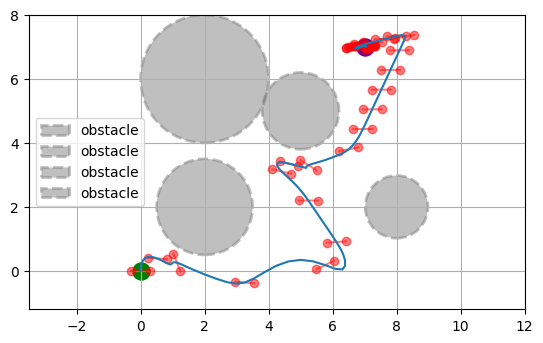

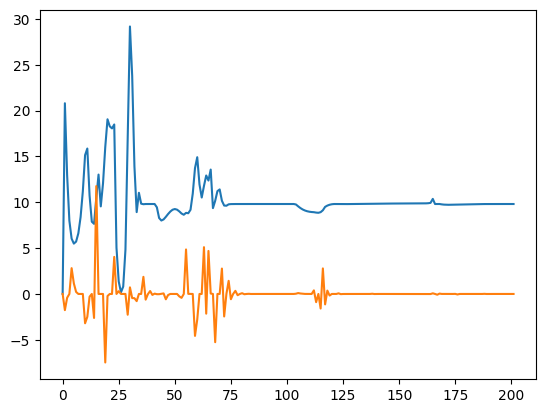

In [169]:
plt.gca().set_aspect('equal', adjustable='box')
# Plot obstacles
for obs_idx in range(len(obs_center)):
    circle = plt.Circle((obs_center[obs_idx][0], obs_center[obs_idx][1]), obs_radius[obs_idx], color='grey', fill=True, linestyle='--', linewidth=2, alpha=0.5)
    plt.gca().add_artist(circle)

ys, zs, phis = states[..., 0], states[..., 2], states[..., 4]
# Plot quadrotor pose
y_ = [(y-l_q*np.cos(phi), y+l_q*np.cos(phi)) for (y, phi) in zip(ys[::7], phis[::7])]
z_ = [(z-l_q*np.sin(phi), z+l_q*np.sin(phi)) for (z, phi) in zip(zs[::7], phis[::7])]
for yy, zz in zip(y_, z_):
  plt.plot(yy, zz, marker="o", color="r", alpha=0.5)

# Plot trajectory
plt.scatter([y], [z], s=150, color="g")
plt.scatter([target_position[0]], [target_position[1]], s=150, color="purple")
plt.plot(states[:, 0], states[:, 2])
plt.xlim(-3.5, 12); plt.ylim(-1.2, 8); plt.grid(); plt.legend()
plt.show()

# Plot control signals
plt.plot(u_actual)
plt.show()